In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from pathlib import Path
import cv2
from tqdm import tqdm


from utils.models.vae import VAE
from utils.models.rnn import RNN
from utils import utils, model_config

import matplotlib.pyplot as plt
from matplotlib import animation, rc
%matplotlib inline

from IPython.display import HTML, Image

Using TensorFlow backend.


In [3]:
rc('animation', html='html5')

## Collect images for training

In [4]:
all_frames = []

In [5]:
frames_1 = utils.get_frames_from_youtube_video("https://www.youtube.com/watch?v=i8dh9gDzmz8", utils.frame_preprocessor)
frames_2 = utils.get_frames_from_youtube_video("https://www.youtube.com/watch?v=SUXWAEX2jlg", utils.frame_preprocessor)

In [6]:
all_frames.extend(frames_1)
all_frames.extend(frames_2)
all_frames = np.array(all_frames)

In [7]:
all_frames.shape

(7200, 64, 64, 3)

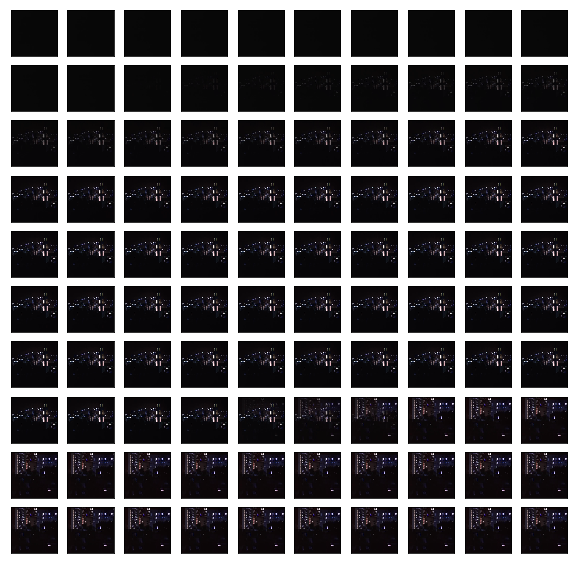

In [8]:
utils.show_image_grid(all_frames, n_images=100, n_rows=10, randomize=False)

## Train VAE

Input is (64, 64, 3) and output is 32 dim vector

In [9]:
vae = VAE.init_default()

In [11]:
vae.train(all_frames, 100)

Train on 5760 samples, validate on 1440 samples
Epoch 1/100
5760/5760 [==============================] - 22s 4ms/step - loss: 691.7496 - vae_r_loss: 675.3150 - vae_kl_loss: 16.4346 - val_loss: 421.4154 - val_vae_r_loss: 404.1882 - val_vae_kl_loss: 17.2272
Epoch 2/100
5760/5760 [==============================] - 21s 4ms/step - loss: 463.7674 - vae_r_loss: 439.7780 - vae_kl_loss: 23.9894 - val_loss: 277.4908 - val_vae_r_loss: 256.3200 - val_vae_kl_loss: 21.1708
Epoch 3/100
5760/5760 [==============================] - 19s 3ms/step - loss: 353.7773 - vae_r_loss: 324.8992 - vae_kl_loss: 28.8781 - val_loss: 243.6376 - val_vae_r_loss: 223.0618 - val_vae_kl_loss: 20.5758
Epoch 4/100
5760/5760 [==============================] - 19s 3ms/step - loss: 293.9518 - vae_r_loss: 262.6136 - vae_kl_loss: 31.3382 - val_loss: 320.8551 - val_vae_r_loss: 294.8608 - val_vae_kl_loss: 25.9943
Epoch 5/100
5760/5760 [==============================] - 19s 3ms/step - loss: 256.4280 - vae_r_loss: 225.0603 - vae_kl_l

In [12]:
encoded_images = vae.encoder.predict(all_frames)
decoded_images = (vae.decoder.predict(encoded_images) * 255).astype(np.uint8)

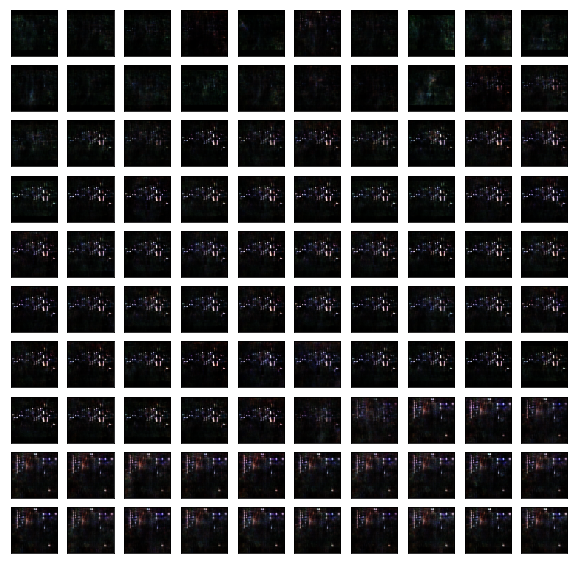

In [13]:
utils.show_image_grid(decoded_images, n_images=100, n_rows=10, randomize=False)

## Train RNN (GRU)

In [14]:
x_rnn_data, y_rnn_data = utils.create_rnn_data(encoded_images, model_config.GRU_TIME_STEPS)

In [15]:
x_rnn_data.shape

(7196, 5, 32)

In [16]:
y_rnn_data.shape

(7196, 32)

In [17]:
rnn = RNN.init_default()

In [18]:
rnn.train(x_rnn_data, y_rnn_data, 100)

Train on 5756 samples, validate on 1440 samples
Epoch 1/100
5756/5756 [==============================] - 2s 383us/step - loss: 0.9271 - acc: 0.2637 - val_loss: 0.8226 - val_acc: 0.2090
Epoch 2/100
5756/5756 [==============================] - 2s 279us/step - loss: 0.9016 - acc: 0.3815 - val_loss: 0.8168 - val_acc: 0.2410
Epoch 3/100
5756/5756 [==============================] - 2s 263us/step - loss: 0.8975 - acc: 0.4102 - val_loss: 0.8137 - val_acc: 0.2604
Epoch 4/100
5756/5756 [==============================] - 2s 273us/step - loss: 0.8961 - acc: 0.4215 - val_loss: 0.8133 - val_acc: 0.2583
Epoch 5/100
5756/5756 [==============================] - 2s 271us/step - loss: 0.8955 - acc: 0.4232 - val_loss: 0.8127 - val_acc: 0.2639
Epoch 6/100
5756/5756 [==============================] - 2s 264us/step - loss: 0.8950 - acc: 0.4295 - val_loss: 0.8119 - val_acc: 0.2667
Epoch 7/100
5756/5756 [==============================] - 2s 261us/step - loss: 0.8946 - acc: 0.4315 - val_loss: 0.8124 - val_acc: 

## Generate new images

In [55]:
n_images_to_generate = 250
start_from_index = 1000
starter_frames = all_frames[start_from_index:start_from_index+model_config.GRU_TIME_STEPS]
generated_encoded_frames = vae.encoder.predict(starter_frames)

for i in range(n_images_to_generate):
    next_frame = rnn.model.predict(np.expand_dims(generated_encoded_frames[i:i + model_config.GRU_TIME_STEPS], axis=0))
    generated_encoded_frames = np.vstack((generated_encoded_frames, next_frame))

In [56]:
generated_encoded_frames = generated_encoded_frames[model_config.GRU_TIME_STEPS:, :]

In [57]:
generated_decoded_frames = vae.decoder.predict(generated_encoded_frames)
generated_decoded_frames = (generated_decoded_frames * 255).astype(np.uint8)

In [58]:
generated_decoded_frames.shape

(250, 64, 64, 3)

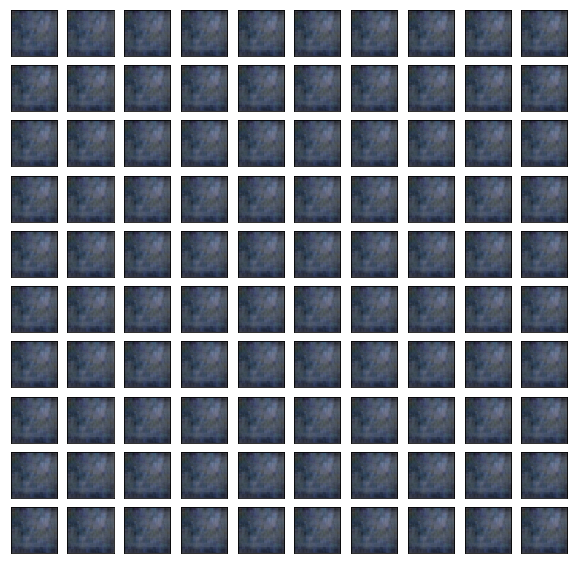

In [59]:
utils.show_image_grid(generated_decoded_frames, n_images=100, n_rows=10, randomize=False)

## Results

In [48]:
from_index = 2500
to_index = 3000

fig = plt.figure(figsize=(5, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Original")
ax1.set_xticks([])
ax1.set_yticks([])
img1 = ax1.imshow(all_frames[0])

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("VAE Encoded then Decoded")
ax2.set_xticks([])
ax2.set_yticks([])
img2 = ax2.imshow(decoded_images[0])
plt.close()

def animate(index_of_frame):
    if index_of_frame % 200 == 0 and index_of_frame != 0:
        print("Done with {0} frames".format(index_of_frame))
    img1.set_data(all_frames[from_index:to_index][index_of_frame])
    img2.set_data(decoded_images[from_index:to_index][index_of_frame])
    return (img1, img2,)

anim = animation.FuncAnimation(fig, animate, frames=(to_index-from_index-1), interval=41, blit=True)

animation_file_path = "./art/vae_decoded_vs_original.gif"
anim.save(animation_file_path, writer='imagemagick', fps=24)

Done with 200 frames
Done with 400 frames


In [49]:
Image(url=animation_file_path)

In [52]:
fig = plt.figure(figsize=(5, 5))

ax1 = fig.add_subplot(1, 1, 1)
ax1.set_title("Generated with VAE and RNN")
ax1.set_xticks([])
ax1.set_yticks([])
img1 = ax1.imshow(generated_decoded_frames[0])
plt.close()

def animate(index_of_frame):
    if index_of_frame % 200 == 0 and index_of_frame != 0:
        print("Done with {0} frames".format(index_of_frame))
    img1.set_data(generated_decoded_frames[index_of_frame])
    return (img1,)

anim = animation.FuncAnimation(fig, animate, frames=len(generated_decoded_frames), interval=41, blit=True)

generated_animation_file_path = "./art/generated_image_sequence.gif"
anim.save(generated_animation_file_path, writer='imagemagick', fps=24)

Done with 200 frames


In [53]:
Image(url=generated_animation_file_path)